In [1]:
import torch

In [2]:
import numpy as np

# Generator Rule
## cell type

- name: 셀 이름
- connection_info: 
    - type: 
        - free: 연결 제한이 없음
        - restricted: 제한이 있음
        
    - restriction_map: 리스트로 해당 index의 cell과 연결될 수 있으면, 연결 가능 갯수 N개 또는 없으면 0

In [3]:
# cell type index: cell name
cell_type_dict = {
    '0': 'entrance',
    '1': 'bed_room',
    '2': 'bath_room',
    '3': 'kitchen',
    '4': 'living_room'
}

number_of_cell_types = len(cell_type_dict)

# entrance
entrance = {
    'name': 'entrance', 
    'type_index': 0,
    'connection_info': 
    {
        'type': 'restricted',
        'restriction_map': [0, 0, 0, 0, 1],
        'minimal_map': [0, 0, 0, 0, 1]
    }
}

# bed room
bed_room = {
    'name': 'bed_room', 
    'type_index': 1,
    'connection_info': 
    {
        'type': 'restricted',
        'restriction_map': [0, 0, 1, 0, 1],
        'minimal_map': [0, 0, 0, 0, 1]
    }
} 

# bath_room
bath_room = {
    'name': 'bath_room', 
    'type_index': 2,
    'connection_info': 
    {
        'type': 'free_with_restricted',
        'restriction_map': [0, 1, 0, 0, 1],
        'minimal_map': [0, 0, 0, 0, 0]
    }
}

# kitchen
kitchen = {
    'name': 'kitchen', 
    'type_index': 3,
    'connection_info': 
    {
        'type': 'restricted',
        'restriction_map': [0, 0, 0, 0, 1],
        'minimal_map': [0, 0, 0, 0, 1]
    }
}

# living_room
living_room = {
    'name': 'living_room', 
    'type_index': 4,
    'connection_info': 
    {
        'type': 'restricted',
        'restriction_map': [1, 5, 1, 1, 0],
        'minimal_map': [1, 5, 0, 1, 0]
    }
}

In [4]:
rules = [entrance, bed_room, bath_room, kitchen, living_room]

In [5]:
class CellRule:
    def __init__(self, name, celltypes=[]):
        self.ruleset = celltypes # list
        self.name = name 
        self.number_of_types = len(celltypes)
        self.types_dict = {
            element['type_index']: element['name'] for element in celltypes}
        self.rule_matrix = [rule['connection_info']['restriction_map'] for rule in celltypes ]
        self.minimal_matrix = [rule['connection_info']['minimal_map'] for rule in celltypes ]

    def __len__(self):
        return self.number_of_types
    
    def __getitem__(self, v):
        return self.types_dict[v]
    
    # cell_type 을 추가한다.
    def add_rule(self):
        name = input('name 입력하세요.')
        type_index = self.number_of_types
        connection_type = input('type 입력하세요.')
        connection_map = input('restriction_map 입력하세요. ex) 0 1 0 0 1').split()
        
        cell_type = {
            'name': name,
            'type_index': type_index,
            'conneciton_info': {
                'type': connection_type,
                'restriction_map': connection_map
            }
        }
        self.ruleset.append(cell_type)
        self.number_of_types += 1
        self.types_dict[type_index] = name
        self.rule_matrix.append(cell_type.connection_info.restriction_map)        
        

In [6]:
cellrule = CellRule('normrule', celltypes = rules)

In [7]:
cellrule.rule_matrix

[[0, 0, 0, 0, 1],
 [0, 0, 1, 0, 1],
 [0, 1, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [1, 5, 1, 1, 0]]

In [8]:
cellrule.minimal_matrix

[[0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [1, 5, 0, 1, 0]]

In [9]:
cellrule.number_of_types

5

In [10]:
cellrule.types_dict

{0: 'entrance', 1: 'bed_room', 2: 'bath_room', 3: 'kitchen', 4: 'living_room'}

In [11]:
import random
import networkx as nx

In [12]:
import copy

In [15]:
class PlanGraph:
    def __init__(self, cellrule):

        self.graph = nx.Graph()
        self.cellrule = cellrule
        
        if not self.cellrule:
            assert self.cellrule    
        
        self.number_of_types = cellrule.number_of_types
        self.types_dict = cellrule.types_dict
        self.max_matrix = cellrule.rule_matrix
        self.rule_matrix = [ [0] * self.number_of_types for _ in range(self.number_of_types) ]
        self.minimal_matrix = cellrule.minimal_matrix.copy()
        
        for index in self.types_dict:
            for coindex in self.types_dict:
                if self.max_matrix[index][coindex] == 0:
                    self.rule_matrix[index][coindex] = 0
                elif self.max_matrix[index][coindex] == 1:
                    self.rule_matrix[index][coindex] = 1
                elif self.max_matrix[index][coindex] > 1:
                    self.rule_matrix[index][coindex] = np.random.randint(self.max_matrix[index][coindex]) + 1

        for index in self.types_dict:
            for coindex in self.types_dict:
                if self.minimal_matrix[index][coindex] == 0:
                    continue
                elif self.minimal_matrix[index][coindex] >= self.rule_matrix[index][coindex]:
                    self.minimal_matrix[index][coindex] = self.rule_matrix[index][coindex]

        self.number_per_types = [0] * self.number_of_types
        self.max_number_per_types = [0] * self.number_of_types
        self.cells_by_type = []
        self.indexed_cells = {}
        self.setNodesByRule()
        
    def getRuleMatrix(self):
        return self.rule_matrix
    
    def getMinimalMatrix(self):
        return self.minimal_matrix
    
    def getCellTypesByCell(self):
        return self.cells_by_type
    
    def setRuleMatrix(self):
        for index in self.types_dict:
            for coindex in self.types_dict:
                if self.max_matrix[index][coindex] == 0:
                    self.rule_matrix[index][coindex] = 0
                elif self.max_matrix[index][coindex] == 1:
                    self.rule_matrix[index][coindex] = 1
                elif self.max_matrix[index][coindex] > 1:
                    self.rule_matrix[index][coindex] = np.random.randint(self.max_matrix[index][coindex]) + 1        

        self.setNodesByRule()
    
    def setPlanGraph(self):
        pass
    
    def setNodesByRule(self):
        self.cells_by_type.clear()
        for index in self.types_dict:
            for node_index in self.types_dict:
                if self.number_per_types[node_index] < self.rule_matrix[index][node_index]:
                    self.number_per_types[node_index] = self.rule_matrix[index][node_index]
                if self.max_number_per_types[node_index] < self.max_matrix[index][node_index]:
                    self.max_number_per_types[node_index] = self.max_matrix[index][node_index]
        for type_index, max_index in enumerate(self.number_per_types):
            for in_index in range(max_index):
                self.graph.add_node(self.types_dict[type_index]+"_"+str(in_index), 
                                    type_index=type_index,
                                    in_index=in_index,
                                    max_connection=self.max_number_per_types[type_index], 
                                    current_connection=self.number_per_types[type_index])
                self.cells_by_type.append(type_index)
        self.nodes_name = list(self.getNodes())
        self.setCellsIndexed()
        
    def setCellsIndexed(self):
        dic = {}
        for key, value in dict(self.getNodes()).items():
            new_key = value['type_index']
            if new_key in dic.keys():
                dic[new_key].append(key)
            else:
                dic[new_key] = []
                dic[new_key].append(key)
        self.indexed_cells = dic
    
    def setEdgesByRule(self):
        self.graph.remove_edges_from(list(self.graph.edges))
        rule_matrix = self.getRuleMatrix()
        minimal_matrix = self.getMinimalMatrix()
        
        cell_stack_dict = copy.deepcopy(self.indexed_cells)
        stack_matrix = [ [0] * self.number_of_types for _ in range(self.number_of_types) ]
        stack_indexed_cell = copy.deepcopy(self.indexed_cells)
        
        for from_type_index, max_cell_number in enumerate(self.number_per_types): 
            for cell_index in range(max_cell_number):
                for to_type_index in range(self.number_of_types):
                    stack_matrix[from_type_index][to_type_index] += minimal_matrix[from_type_index][to_type_index]
        
        for index in self.types_dict:
            for node_index in self.types_dict:
                if stack_matrix[index][node_index] > stack_matrix[node_index][index]:
                    stack_matrix[node_index][index] = stack_matrix[index][node_index]

        for from_type_index, max_cell_number in enumerate(self.number_per_types): 
            for cell_index in range(max_cell_number):
                for to_type_index in range(self.number_of_types):
                    connection_number = stack_matrix[from_type_index][to_type_index]
                    
                    if connection_number == 0:
                        continue
                    else:
                        if not len(stack_indexed_cell[from_type_index]) == 1 and not len(stack_indexed_cell[to_type_index]) == 1:
                            self.graph.add_edge(stack_indexed_cell[from_type_index].pop(0),
                                           stack_indexed_cell[to_type_index].pop(-1))
                        elif not len(stack_indexed_cell[from_type_index]) == 1:
                            self.graph.add_edge(stack_indexed_cell[from_type_index].pop(0),
                                           stack_indexed_cell[to_type_index][-1])
                        elif not len(stack_indexed_cell[to_type_index]) == 1:
                            self.graph.add_edge(stack_indexed_cell[from_type_index][-1],
                                           stack_indexed_cell[to_type_index].pop(-1))
                        else:
                            self.graph.add_edge(stack_indexed_cell[from_type_index][-1],
                                           stack_indexed_cell[to_type_index][-1])
                        stack_matrix[to_type_index][from_type_index] =- 1
                        stack_matrix[from_type_index][to_type_index] =- 1
        
        for index in self.types_dict:
            for node_index in self.types_dict:
                if not stack_matrix[index][node_index] == 0:
                    assert stack_matrix
        
        for test_index, rule in enumerate(self.getMinimalMatrix()):
            non_free = filter(lambda cell_index: 0 != cell_index, rule)
            if not list(non_free):
                from_index = test_index
                rule_matrix = self.getRuleMatrix()
                stack = []
                
                for target_index, rule in enumerate(rule_matrix):
                    if not rule[from_index] == 0:
                        stack.append(target_index)
                
                stack_size = len(stack)
                target_index = np.random.randint(stack_size)
                
                self.graph.add_edge(cell_stack_dict[from_index][0],
                                   cell_stack_dict[stack[target_index]][0])   
    
    def getGraph(self):
        return self.graph
    
    def drawGraph(self, with_labels=False):
        nx.draw(self.graph, with_labels=with_labels)
        
    def getNodes(self):
        return self.graph.nodes
        
        

In [16]:
pg = PlanGraph(cellrule)

In [17]:
pg.getRuleMatrix()

[[0, 0, 0, 0, 1],
 [0, 0, 1, 0, 1],
 [0, 1, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [1, 4, 1, 1, 0]]

In [18]:
pg.max_matrix

[[0, 0, 0, 0, 1],
 [0, 0, 1, 0, 1],
 [0, 1, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [1, 5, 1, 1, 0]]

In [19]:
pg.minimal_matrix

[[0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [1, 4, 0, 1, 0]]

In [20]:
pg.number_per_types

[1, 4, 1, 1, 1]

In [21]:
pg.setNodesByRule()

In [22]:
pg.max_number_per_types

[1, 5, 1, 1, 1]

In [23]:
pg.cells_by_type

[0, 1, 1, 1, 1, 2, 3, 4]

In [24]:
pg.indexed_cells

{0: ['entrance_0'],
 1: ['bed_room_0', 'bed_room_1', 'bed_room_2', 'bed_room_3'],
 2: ['bath_room_0'],
 3: ['kitchen_0'],
 4: ['living_room_0']}

In [25]:
pg.types_dict

{0: 'entrance', 1: 'bed_room', 2: 'bath_room', 3: 'kitchen', 4: 'living_room'}

In [26]:
pg.drawGraph(with_labels=True)

In [27]:
pg.setEdgesByRule()

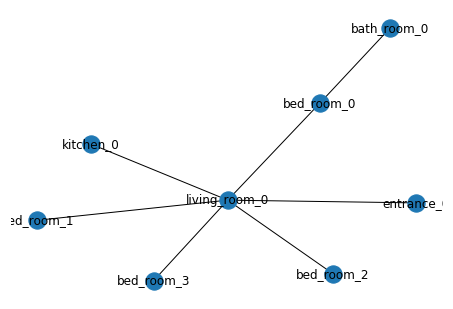

In [28]:
pg.drawGraph(with_labels=True)